In [2]:
import jax
import jax.numpy as np
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
%matplotlib inline

# Auxiliary Functions

In [3]:
# Use double precision to generate data (due to GP sampling)
#https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/blob/main/Diffusion-reaction/PI_DeepONet_DR.ipynb
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [4]:
# A diffusion-reaction numerical solver
#https://github.com/PredictiveIntelligenceLab/Physics-informed-DeepONets/blob/main/Diffusion-reaction/PI_DeepONet_DR.ipynb
def solve_ADR(key, Nx, Nt, P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))
    u = u.at[:,0].set(u0(x))
    #u = index_update(u, index[:,0], u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        u = u.at[1:-1, i + 1].set(np.linalg.solve(A, b1 + b2))
        #u = index_update(u, index[1:-1, i + 1], np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u, y, s)

In [5]:
# Plots
def plot(X,T,f):
  fig = plt.figure(figsize=(7,5))
  plt.pcolor(X,T,f, cmap='rainbow')
  plt.colorbar()
  plt.xlabel('$x$')
  plt.ylabel('$t$')
  plt.title('$f(x,t)$')
  plt.tight_layout()

# **Introduction**

## **Functions and Operators:**

### **Function:**

 Maps between vector spaces:

*Example:*

Let $f_1(x)=sin(x)$; for  $x\in\mathbf{R}$

$$z=f_1(x)=sin(x)\in[0:1]$$

In other words $f_1$ maps $\mathbf{R}→[0,1]$

### **Operator:**

 Maps between infinite-dimensional function spaces:
$$G(f_1(x))=f_2(x)$$

*Example:*

Derivative Operator →$\frac{d}{d x}$

It transforms a funcion $f_1$ into a function $f_2$:

Let $f_1(x)=sin(x)$

Then when we apply our operator:

$$f_2=\frac{df_1(x)}{d x}=\frac{d}{d x}sin(x)=cos(x)$$


### **Parametric PDEs and Operators**

Parametric PDEs $\rightarrow$ Some parameters (e.g., shape, IC/BC, coefficients, etc.) of a given PDE system are allowed to change.

Let  $\mathcal{N}$ be a nonlinear differential operator. Let's consider parametric PDEs of the form:

$$\mathcal{N}(u,s)=0$$

where, $u$ is the input function, and $s$ is the unknown PDE's solution (also a function.)

Our PDE solution operator would be:

$$G(u)=s$$

**Note 1:**In other words, we can express the general solution of our PDE as an operator $G$

**Note 2:** Remember $s$ is itself a function, so if we evaluate it at any point $y$, the answer would be a real number:

 $$G(u)(y)=s(y)\in \mathbf{R}$$

 ### **Universal Approximation Theorem for Operator**

 $\forall \epsilon >0$, there are positive integers $n,p,m$, constants $c_i^k,W_{bij}^k,b_{bij}^k,W_{tk},b_{tk}$ such that:

$$\left|G(u)(y)-\sum_{k=1}^{p}\sum_{i=1}^{n}c_i^k\sigma\left(\sum_{j=1}^{m}W_{bij}^{k}u(x_j)+b_{bi}^k\right).\sigma(W_{tk}.y+b_{tk})\right|<\epsilon $$

 ### **Neural Network**

A Neural Network is a function that takes the form: (See:https://book.sciml.ai/notes/03/)

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2\sigma_1(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

So we can use 2 NNs to implement the Universal Approximation Theorem for Operator i.e.

Branch:

$$NN_b(u(\textbf{x}))=b(u(\textbf{x}))=\textbf{c}.\sigma\left(W_{b}u(\textbf{x})+\textbf{b}_{b}\right)$$

Trunk:


$$NN_t(\textbf{y})=t(\textbf{y})=\sigma(W_{t}.\textbf{y}+\textbf{b}_{t})$$

### **DeepOnet**

Learn the solution operators of parametric PDEs → We will try to approximate $G$  (the solution of our PDE operator) by two neural networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$G_\theta(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$\mathcal{L}_{Operator}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$$


$$\mathcal{L}_{Operator}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|\sum_{k=1}^q{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}.t_k(y_j^{(i)})-G(u^{(i)})y_j^{(i)}\right|^2$$

where:

$m:$ Number of points at which we evaluated our input functions.

$N:$ Number of input functions.

$P:$ Number of points at which we evaluate the output function → output sensors.


# Physics-informed DeepONets


Similar to a PINN, a Physics-informed DeepONets output functions consistent with physical constraints by minimizing the residual of an underlying governing law (i.e., nonlinear differential operator).

$$\mathcal{L}_{Physics}(\theta)=\frac{1}{NQm}\sum_{i=1}^{N}\sum_{j=1}^{Q}\sum_{k=1}^{m}\left|\mathcal{N}(u^{(i)}(x_k),G_{\theta}(u^{(i)})(y_j^{(i)})\right|^2$$

where $\mathcal{N}$ is a nonlinear differential operator, and $\{y_j\}_{i=1}^{Q}$ are the collocation points ( we use them to enforce the physical constraint).

So the total loss would be:

$$\mathcal{L}(\theta)=\mathcal{L}_{Operator}(\theta)+\mathcal{L}_{Physics}(\theta)$$







# Problem Setup

**Diffusion-reaction system**

Implicit operator described by a nonlinear PDE with a source term $u(x)$:

$$\frac{\partial s}{\partial t}=D\frac{\partial^2 s}{\partial x^2}+ks^2+u(x)$$

$$(x,t)\in (0,1,]\times(0,1]$$

where, $D=0.01$ is the diffusion coefficient and $k=0.01$ is the reaction rate.

**Note:** We will not use any paired input-output data. We only know that  the initial and boundary conditions  are zero.


**Training**

We will map the source terms $u(x)$ to the PDE solution $s(x,t)$. Hence, we will approximate the implicit solution operator ($G$) with a PI-DeepONet ($G_{\theta}$).

From our PDE, we know that for a given input function $u^{(i)}$:

$$u^{(i)}=\frac{\partial s^{(i)}}{\partial t}-D\frac{\partial^2 s^{(i)}}{\partial x^2}-k[s^{(i)}]^2 $$

So since ideally $G_{\theta}(u^{(i)})(x,t)\approx G(u^{(i)})(x,t)= s^{(i)}(x,t)$ :
$$u^{(i)}\approx \frac{\partial G_{\theta}(u^{(i)})(x,t)}{\partial t}-D\frac{\partial^2 G_{\theta}(u^{(i)})(x,t)}{\partial x^2}-k[G_{\theta}(u^{(i)})(x,t)]^2 $$

Lets call:
$$R_{\theta}^{(i)}(x,t)=\frac{\partial G_{\theta}(u^{(i)})(x,t)}{\partial t}-D\frac{\partial^2 G_{\theta}(u^{(i)})(x,t)}{\partial x^2}-k[G_{\theta}(u^{(i)})(x,t)]^2 $$
So our $\mathcal{L}_{Physics}$ will be:


$$\mathcal{L}_{Physics}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|R_{\theta}^{(i)}(x_{r,j}^{(i)},t_{r,j}^{(i)})-u^{(i)}(x_{r,j}^{(i)})\right|^2$$

where $(x_{r,j},t_{r,j})$ are the "collocation points" (i.e., where we evaluate our PDE).

On the other hand we will enforce our zero initial and boundary conditions with the $\mathcal{L}_{Operator}(\theta)$:


$$\mathcal{L}_{Operator}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|G_{\theta}(u^{(i)})(x_{u,j}^{(i)},t_{u,j}^{(i)})- G(u^{(i)})(x_{u,j}^{(i)},t_{u,j}^{(i)}))\right|^2$$

where, $(x_{u,j},t_{u,j})$ are points form our initial and boundary conditions. Consequently, since we are working with zero initial and boundary conditions $G(u^{(i)})(x_{u,j}^{(i)},t_{u,j}^{(i)})=0$ and:


$$\mathcal{L}_{Operator}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{P}\left|G_{\theta}(u^{(i)})(x_{u,j}^{(i)},t_{u,j}^{(i)})))\right|^2$$

Finally, the total loss will be: 
$$\mathcal{L}(\theta)=\mathcal{L}_{operator}(\theta)+\mathcal{L}_{Physics}(\theta)$$



**In summary:**

*   Let $y=(x,t)$.
*   Also remember that $u$ is only a function of $x$.

To train a PI-DeepOnet:

1.   Select $N$ source terms (i.e, input functions) →$\{u^{(i)}(\textbf{x})\}_{i=1}^{N}={[u^{(1)}(\textbf{x}),u^{(2)}(\textbf{x}),...,u^{(N)}(\textbf{x})]}$.
2.   Evaluate our $N$ functions at $m$ points (i.e., input sensors) →$\begin{bmatrix}u^{(1)}(x_1)&u^{(1)}(x_2)&...&u^{(1)}(x_m)\\
u^{(2)}(x_1)&u^{(2)}(x_2)&...&u^{(2)}(x_m)\\
\vdots&\vdots&\ddots&\vdots\\
u^{(N)}(x_1)&u^{(N)}(x_2)&...&u^{(N)}(x_m)\end{bmatrix}$
3.   Send the $m$ outputs of our $N$ functions to our **branch network** → $b_k\begin{pmatrix}u^{(1)}(x_1)&u^{(1)}(x_2)&...&u^{(1)}(x_m)\\
u^{(2)}(x_1)&u^{(2)}(x_2)&...&u^{(2)}(x_m)\\
\vdots&\vdots&\ddots&\vdots\\
u^{(N)}(x_1)&u^{(N)}(x_2)&...&u^{(N)}(x_m)\end{pmatrix}$
4.   Select $P$ points (i.e., output sensors) from our boundary and initial conditions → $\textbf{y}_u=y_{u1},y_{u2},...,y_{uP}$
5.  Send our output sensors to our **trunk network**→$t_k(y_{u1},y_{u2},...,y_{uP})$
6. Approximate our operator by computing the dot product between the output of our **branch network** and the output of our **trunk network**→ $G_\theta(u)(\textbf{y})=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$
7. Ideally $G_\theta(u)(\textbf{y}_u)\approx G(u)(\textbf{y}_u)=0$, so compute the error → $\mathcal{L}_{Operator}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_{uj}^{(i)}\right|^2$
8. Select $Q$ points (i.e., collocation points) inside our domain → $\textbf{y}_r=y_{r1},y_{r2},...,y_{rQ}$
9. Compute the error related to the underlying governing laws (i.e., PDE)→$\mathcal{L}_{Physics}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|R_{\theta}^{(i)}(y_{r,j}^{(i)})-u^{(i)}(x_{r,j}^{(i)})\right|^2$

10. Compute the total loss→$\mathcal{L}(\theta)=\mathcal{L}_{operator}(\theta)+\mathcal{L}_{Physics}(\theta)$
11. Update our NN parameters (i.e., branch and trunk) to minimize  $\mathcal{L}(\theta)$.
12. Repeat the process until $G_\theta(u)(x,t)\approx G(u)(x,t)$.

# Data Generation

We will randomly sample 5000 different functions $u$ from a zero-mean Gaussian process with an exponential quadratic kernel with a length scale: $l=0.2$.

In [6]:
# GRF length scale
length_scale = 0.2
N = 5000 # number of input samples

## Generate a random function


Let: $$(x,t)\in (0,1]\times(0,1]$$
Lets create a random function:
$$UU=f(x,t)$$
We select $P=300$ points from our BC and IC (i.e., $100/side$)
$$y_u=\{(x_{u1},t_{u2}),(x_{u1},t_{u2}),...,(x_{uQ},t_{uQ})\}$$
We select $Q=100$ collocation points to evaluate our PDE.
$$y_r=\{(x_{r1},t_{r2}),(x_{r1},t_{r2}),...,(x_{rQ},t_{rQ})\}$$


In [7]:
# Resolution of the solution (Grid of 100x100)
Nx = 100
Nt = 100
# Select the number of sensors
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side 
Q_train = 100  # number of collocation points for each input sample

In [8]:
config.update("jax_enable_x64", True)
# Numerical solution
key = random.PRNGKey(0)
(x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P_train, length_scale)

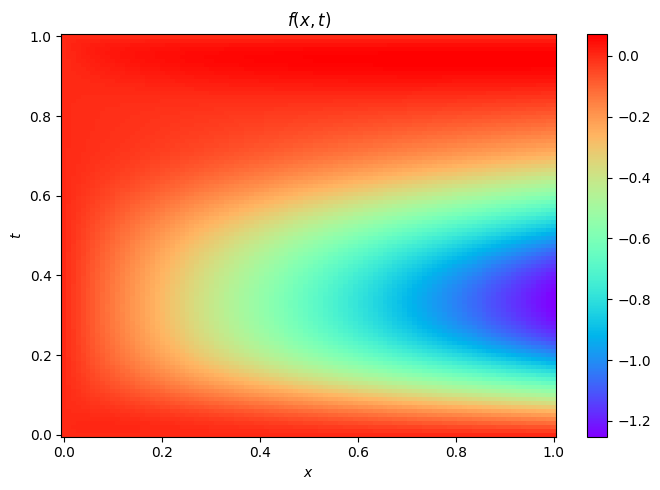

In [9]:
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)
plot(XX,TT,UU)

### Training Data for one function

#### IC/BCC

Ideally $G_\theta(u)(\textbf{y}_u)\approx G(u)(\textbf{y}_u)=0$, so compute the error → $\mathcal{L}_{Operator}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_{uj}^{(i)}\right|^2$

In [10]:
# Sample points from the boundary and the inital conditions
# Geneate subkeys 
subkeys = random.split(key, 4)
# Here we regard the initial condition as a special type of boundary conditions
x_bc1 = np.zeros((P_train // 3, 1))
x_bc2 = np.ones((P_train // 3, 1))
x_bc3 = random.uniform(key = subkeys[0], shape = (P_train // 3, 1))
x_bcs = np.vstack((x_bc1, x_bc2, x_bc3))
#Time
t_bc1 = random.uniform(key = subkeys[1], shape = (P_train//3 * 2, 1)) # 200 points
t_bc2 = np.zeros((P_train//3, 1)) # 100 points
t_bcs = np.vstack([t_bc1, t_bc2])
# Training data for BC and IC
u_train = np.tile(u, (P_train,1)) # Add dimentions-> copy u P times
y_train = np.hstack([x_bcs, t_bcs]) # stack the
s_train = np.zeros((P_train, 1)) # Remember that the initial conditions are 0

#### Collocation Points

Select $Q$ points (i.e., collocation points) inside our domain → $\textbf{y}_r=y_{r1},y_{r2},...,y_{rQ}$

Compute the error related to the underlying governing laws (i.e., PDE)→$\mathcal{L}_{Physics}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|R_{\theta}^{(i)}(y_{r,j}^{(i)})-u^{(i)}(x_{r,j}^{(i)})\right|^2$

$$R_{\theta}^{(i)}(y_{r,j}^{(i)})=\frac{\partial G_{\theta}(u^{(i)})(y_{r,j}^{(i)})}{\partial t}-D\frac{\partial^2 G_{\theta}(u^{(i)})(y_{r,j}^{(i)})}{\partial x^2}-k[G_{\theta}(u^{(i)})(y_{r,j}^{(i)})]^2 $$

In [11]:
# Sample collocation points
x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q_train,1),replace=False)
x_r = x[x_r_idx]
t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q_train,1))

# Training data for the PDE residual
u_r_train = np.tile(u, (Q_train,1))
y_r_train = np.hstack([x_r, t_r])
f_r_train = u[x_r_idx] 

## Training Data




We need to generate 5000 functions, so lets create a function to help us with the training and testing data


In [12]:
# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    # Geneate subkeys
    subkeys = random.split(key, 4)

    # Sample points from the boundary and the inital conditions
    # Here we regard the initial condition as a special type of boundary conditions
    x_bc1 = np.zeros((P // 3, 1))
    x_bc2 = np.ones((P // 3, 1))
    x_bc3 = random.uniform(key = subkeys[0], shape = (P // 3, 1))
    x_bcs = np.vstack((x_bc1, x_bc2, x_bc3))

    t_bc1 = random.uniform(key = subkeys[1], shape = (P//3 * 2, 1))
    t_bc2 = np.zeros((P//3, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    # Training data for BC and IC
    u_train = np.tile(u, (P,1))
    y_train = np.hstack([x_bcs, t_bcs])
    s_train = np.zeros((P, 1))

    # Sample collocation points
    x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q,1))
    x_r = x[x_r_idx]
    t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q,1))

    # Training data for the PDE residual
    '''For the operator'''
    u_r_train = np.tile(u, (Q,1))
    y_r_train = np.hstack([x_r, t_r])
    '''For the function'''
    f_r_train = u[x_r_idx]
    return u_train, y_train, s_train, u_r_train, y_r_train, f_r_train

In [13]:
# GRF length scale
length_scale = 0.2

# Resolution of the solution
Nx = 100
Nt = 100

N = 5000 # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side 
Q_train = 100  # number of collocation points for each input sample

In [14]:
# Select N keys to create N Functions
key = random.PRNGKey(0)
keys = random.split(key, N)

In [15]:
config.update("jax_enable_x64", True)
u_train, y_train, s_train, u_r_train, y_r_train, f_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P_train, Q_train)

In [16]:
# Reshape the data 
u_bcs_train = np.float32(u_train.reshape(N * P_train,-1))
y_bcs_train = np.float32(y_train.reshape(N * P_train,-1))
s_bcs_train = np.float32(s_train.reshape(N * P_train,-1))

u_res_train = np.float32(u_r_train.reshape(N * Q_train,-1))
y_res_train = np.float32(y_r_train.reshape(N * Q_train,-1))
f_res_train = np.float32(f_r_train.reshape(N * Q_train,-1))

## Testing Data

In [17]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

In [18]:
N_test = 100 # number of input samples 
key = random.PRNGKey(12345) # it should be different than the key we used for the training data
P_test = 100
Nx = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

In [ ]:
config.update("jax_enable_x64", False)

In [ ]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample
        self.y = y # location
        self.s = s # labeled data evulated at y (solution measurements, BC/IC conditions, etc.)
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

#DeepONet

In [ ]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

**In summary:**

*   Let $y=(x,t)$.
*   Also remember that $u$ is only a function of $x$.

To train a PI-DeepOnet:

1.   Select $N$ source terms (i.e, input functions) →$\{u^{(i)}(\textbf{x})\}_{i=1}^{N}={[u^{(1)}(\textbf{x}),u^{(2)}(\textbf{x}),...,u^{(N)}(\textbf{x})]}$.
2.   Evaluate our $N$ functions at $m$ points (i.e., input sensors) →$\begin{bmatrix}u^{(1)}(x_1)&u^{(1)}(x_2)&...&u^{(1)}(x_m)\\
u^{(2)}(x_1)&u^{(2)}(x_2)&...&u^{(2)}(x_m)\\
\vdots&\vdots&\ddots&\vdots\\
u^{(N)}(x_1)&u^{(N)}(x_2)&...&u^{(N)}(x_m)\end{bmatrix}$
3.   Send the $m$ outputs of our $N$ functions to our **branch network** → $b_k\begin{pmatrix}u^{(1)}(x_1)&u^{(1)}(x_2)&...&u^{(1)}(x_m)\\
u^{(2)}(x_1)&u^{(2)}(x_2)&...&u^{(2)}(x_m)\\
\vdots&\vdots&\ddots&\vdots\\
u^{(N)}(x_1)&u^{(N)}(x_2)&...&u^{(N)}(x_m)\end{pmatrix}$
4.   Select $P$ points (i.e., output sensors) from our boundary and initial conditions → $\textbf{y}_u=y_{u1},y_{u2},...,y_{uP}$
5.  Send our output sensors to our **trunk network**→$t_k(y_{u1},y_{u2},...,y_{uP})$
6. Approximate our operator by computing the dot product between the output of our **branch network** and the output of our **trunk network**→ $G_\theta(u)(\textbf{y})=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$
7. Ideally $G_\theta(u)(\textbf{y}_u)\approx G(u)(\textbf{y}_u)=0$, so compute the error → $\mathcal{L}_{Operator}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_{uj}^{(i)}\right|^2$
8. Select $Q$ points (i.e., collocation points) inside our domain → $\textbf{y}_r=y_{r1},y_{r2},...,y_{rQ}$
9. Compute the error related to the underlying governing laws (i.e., PDE)→$\mathcal{L}_{Physics}(\theta)=\frac{1}{NQ}\sum_{i=1}^{N}\sum_{j=1}^{Q}\left|R_{\theta}^{(i)}(y_{r,j}^{(i)})-u^{(i)}(x_{r,j}^{(i)})\right|^2$

10. Compute the total loss→$\mathcal{L}(\theta)=\mathcal{L}_{operator}(\theta)+\mathcal{L}_{Physics}(\theta)$
11. Update our NN parameters (i.e., branch and trunk) to minimize  $\mathcal{L}(\theta)$.
12. Repeat the process until $G_\theta(u)(x,t)\approx G(u)(x,t)$.

The residual will be:

$$R_{\theta}^{(i)}(y_{r,j}^{(i)})=\frac{\partial G_{\theta}(u^{(i)})(y_{r,j}^{(i)})}{\partial t}-D\frac{\partial^2 G_{\theta}(u^{(i)})(y_{r,j}^{(i)})}{\partial x^2}-k[G_{\theta}(u^{(i)})(y_{r,j}^{(i)})]^2 $$

In [ ]:
# Define the model
class PI_DeepONet:
    def __init__(self, branch_layers, trunk_layers):    
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        outputs = np.sum(B * T)
        return  outputs
  
    # Define ODE/PDE residual
    def residual_net(self, params, u, x, t):
        s = self.operator_net(params, u, x, t)
        s_t = grad(self.operator_net, argnums=3)(params, u, x, t)
        s_x = grad(self.operator_net, argnums=2)(params, u, x, t)
        s_xx= grad(grad(self.operator_net, argnums=2), argnums=2)(params, u, x, t)

        res = s_t - 0.01 * s_xx - 0.01 * s**2 
        return res

    # Define boundary loss
    def loss_bcs(self, params, batch):
        inputs, outputs = batch
        u, y = inputs

        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred)**2)
        return loss

    # Define residual loss
    def loss_res(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((outputs.flatten() - pred)**2)
        return loss   

    # Define total loss
    def loss(self, params, bcs_batch, res_batch):
        loss_bcs = self.loss_bcs(params, bcs_batch)
        loss_res = self.loss_res(params, res_batch)
        loss = loss_bcs + loss_res
        return loss 

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, bcs_dataset, res_dataset, nIter = 10000):
        # Define data iterators
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, bcs_batch, res_batch)
            
            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_value = self.loss(params, bcs_batch, res_batch)
                loss_bcs_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                # Store losses
                self.loss_log.append(loss_value)
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)

                # Print losses
                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_bcs' : loss_bcs_value, 
                                  'loss_physics': loss_res_value})
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

## Initialize DeepONet

In [ ]:
# Initialize model
branch_layers = [m, 50, 50, 50, 50, 50]
trunk_layers =  [2, 50, 50, 50, 50, 50]
model = PI_DeepONet(branch_layers, trunk_layers)

In [ ]:
# Create data set
batch_size = 10000
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, f_res_train, batch_size)

# Train

In [ ]:
# Train
model.train(bcs_dataset, res_dataset, nIter=40000)

100%|██████████| 120000/120000 [45:38<00:00, 43.82it/s, Loss=6.180332e-05, loss_bcs=1.8806511e-05, loss_physics=4.2996813e-05]


# Evaluate

### Results for 100 test functions

In [ ]:
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)[:,None]
error_s = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test)
print(error_s)

0.0071554612


### Result for 1 test function

In [ ]:
N_test = 1 # number of input samples 
key = random.PRNGKey(456)
P_test = 100
Nx = m
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
u_test = np.float32(u_test.reshape(N_test * P_test**2,-1))
y_test = np.float32(y_test.reshape(N_test * P_test**2,-1))
s_test = np.float32(s_test.reshape(N_test * P_test**2,-1))

In [ ]:
# Predict
params = model.get_params(model.opt_state)
s_pred = model.predict_s(params, u_test, y_test)


In [ ]:
# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

In [ ]:
# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

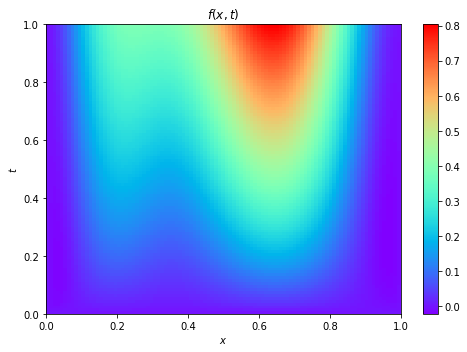

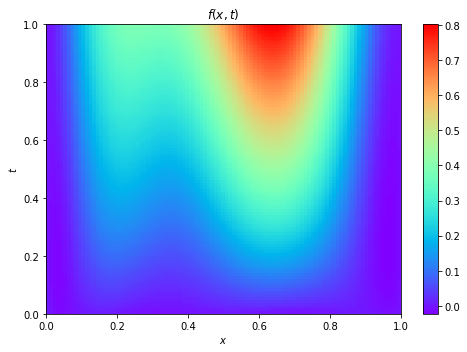

In [ ]:
#Real
plot(XX,TT, S_test)
#Prediction
plot(XX,TT, S_pred)

In [ ]:
#Compute the Error
error_s = np.linalg.norm(S_test - S_pred) / np.linalg.norm(S_test)
print(error_s)

0.006711102955147286


# References

[1] Lu, L., Jin, P., & Karniadakis, G. E. (2019). Deeponet: Learning nonlinear operators for identifying differential equations based on the universal approximation theorem of operators. arXiv preprint arXiv:1910.03193.

[2] Wang, S., Wang, H., & Perdikaris, P. (2021). Learning the solution operator of parametric partial differential equations with physics-informed DeepONets. Science advances, 7(40), eabi8605.